# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [1]:
# basics
import math
import os 

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# linear modeling
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#K-Fold cross-validation
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# scale the data
from sklearn.preprocessing import StandardScaler

# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

Load in the data

In [2]:
# # optional directory set-up
# working_dir = !pwd
# train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
# test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
# sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

# Load data (Specific to Deva)
test = pd.read_csv("../../housing_data/test.csv")
train = pd.read_csv("../../housing_data/train.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")
print(test.shape)
print(train.shape)

(1459, 80)
(1460, 81)


In [3]:
# train =pd.read_csv('C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/test.csv")
# sample = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv")

# print("train shape: {}".format(train.shape))
# print("test shape: {}".format(test.shape))

## Data cleaning

Deal with missing values

In [4]:
print("Count number of missing values per variable:")
print(train.isnull().sum()[train.isnull().sum() != 0])

# function to clean the missing values
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)

# make sure there are no more missing values
print("\nNumber of missing values after running na_clean()")
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Count number of missing values per variable:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Number of missing values after running na_clean()
Missing values in train: 0
Missing values in test: 0


## Feature Engineering

Simplifying the data for any future model we use

In [5]:
# keep adapting this formula to change how we feature engineer
def feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    
    
    # deciding to drop a few features for various reasons
    vars_to_drop = [
        "LowQualFinSF", # hardly any variation
        "LandSlope", # not much variation
        "PoolArea", # binarized above
        "MiscVal", # not much variation
        "Utilities", # only 1 obs in training data different from regular
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    ### JARED EDITS
    # minimal transformations.
    
    # for some vars values are 0, since ln(0) = -inf, I have to recode values of 0 to 1
    # as ln(1) =0. 
    
    #for x in range(len(df.BsmtFinSF1)):
    #    if df['BsmtFinSF1'][x] ==0:
    #        df['BsmtFinSF1'][x] = 1
        
    #for x in range(len(df.MasVnrArea)):
    #    if df['MasVnrArea'][x] ==0:
    #        df['MasVnrArea'][x] = 1
    
    #for x in range(len(df.GarageArea)):
    #    if df['GarageArea'][x] ==0:
    #        df['GarageArea'][x] = 1
    
    for x in range(len(df.TotalBsmtSF)):
        if df['TotalBsmtSF'][x] ==0:
            df['TotalBsmtSF'][x] = 1
            
    #for x in range(len(df.WoodDeckSF)):
    #    if df['WoodDeckSF'][x] ==0:
    #        df['WoodDeckSF'][x] = 1
    
    df.Total_Inside_Area = np.log(df.Total_Inside_Area)
    df.TotalBsmtSF = np.log(df.TotalBsmtSF)
    #df.GarageArea = np.log(df.GarageArea)  
    #df.BsmtFinSF1 = np.log(df.BsmtFinSF1)
    df.LotArea = np.log(df.LotArea)
    #df.WoodDeckSF = np.log(df.WoodDeckSF)
    #df.MasVnrArea = np.log(df.MasVnrArea)

    
    ###
    
    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

In [6]:
# run function on test and train
train = feature_eng(train)
test = feature_eng(test, test_data=True)

<ipython-input-5-6a284f422525>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalBsmtSF'][x] = 1
<ipython-input-5-6a284f422525>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalBsmtSF'][x] = 1


# Modeling

## Linear Model

Function to prep data for a very baseline linear model

In [7]:
def lm_df_clean(df):

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Get train/test data all ready

In [8]:
X_train = lm_df_clean(train)
X_test = lm_df_clean(test)
Y_train = train.SalePrice
Y_test = sample.SalePrice

Baseline linear model is very overfit

In [9]:
# Decent R2
from sklearn.linear_model import LinearRegression
lr_1 = LinearRegression(fit_intercept=True)
lr_1.fit(X_train,Y_train)

print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))


Fit on training data: 0.855
Fit on testing data: -17.670


Same feature set with a baseline RandomForest is also overfit

In [10]:
dt = DecisionTreeRegressor(random_state = 0)
dt.fit(X_train, Y_train)

print("Fit on training data: {:.3f}".format(dt.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(dt.score(X_test ,Y_test)))

Fit on training data: 1.000
Fit on testing data: -18.893


Basic linear model with single coefficient

In [11]:
#Simplest possible model - Chose variable with highest coefficient from initial correlation matrix

X_train_2 = train.drop(train.columns.difference(['OverallQual']), 1)
X_test_2 = test.drop(test.columns.difference(['OverallQual']), 1)
Y_train = train.SalePrice
Y_test = sample.SalePrice

lr_2 = LinearRegression(fit_intercept=True)
lr_2.fit(X_train_2,Y_train)

print("Fit on training data: {:.3f}".format(lr_2.score(X_train_2,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_2.score(X_test_2 ,Y_test)))

Fit on training data: 0.626
Fit on testing data: -14.882


## Random forest with cross validation

In [12]:
# preprocess the data
train_dummies = pd.get_dummies(train)

# create the train and test splits
dev_train, dev_test = train_test_split(train_dummies, test_size=0.3, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto')

# run grid search on range of values
grid = {
    "n_estimators": np.arange(100, 1001, 100),
    'max_depth': np.arange(10, 101, 5),
    'min_samples_split': [2, 5, 7],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
# this took 26 min to run. 
# re-run if you want
#results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# check out the best parameters
#print(results.best_params_)
# {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 900}

In [13]:

for i in dev_train:
    for x in dev_train[i]:
        if x ==np.inf:
            print(i)
        elif x ==-np.inf:
            print(i)

        


In [14]:
# finally, run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# evaluate it's performance on the unforseen testing set
yhat = rf_reg.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))
resids = yhat - dev_test.LogSalePrice

# evaluate rmse and mae on the testing data
print("MAE: " + str(round(np.mean(resids.apply(lambda x: math.fabs(x))),4)))
print("RMSE: " + str(round(np.mean(resids**2)**.5,4)))
# MAE: 0.0999
# RMSE: 0.154

MAE: 0.1005
RMSE: 0.1545


In [15]:
# score on train
rf_train_score = rf_reg.score(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
print("Score on train: {:.3f}".format(rf_train_score))

# score on test/dev
rf_dev_score = rf_reg.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice)
print("Score on test: {:.3f}".format(rf_dev_score))

Score on train: 0.981
Score on test: 0.874


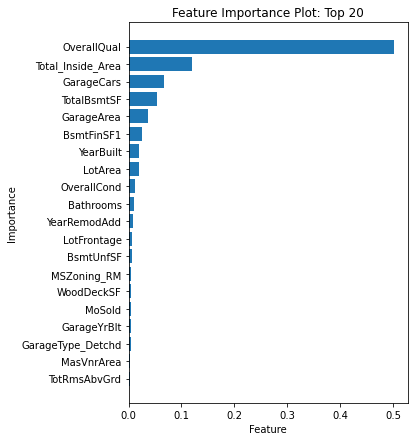

In [16]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")


## Lasso Regression

In [17]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # iterate over every vbalkue of alpha in the list, fit lasso regression
    model = Lasso(alpha = i)

    # copying Trevor's code, delete certain variables that don't matter
    model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # run 10-fold Cross validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

<ipython-input-17-6bab5841d68a>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.628430460973907, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.087 (0.012)
Accuracy: 0.9096173100577971


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6284312063829933, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.087 (0.012)
Accuracy: 0.9096185787818667
Lasso alpha is equal to:  0.0001
Mean MAE: 0.081 (0.012)
Accuracy: 0.9132507746324088
Lasso alpha is equal to:  0.001
Mean MAE: 0.083 (0.009)
Accuracy: 0.8940152758144915
Lasso alpha is equal to:  0.01
Mean MAE: 0.105 (0.013)
Accuracy: 0.859686813280689
Lasso alpha is equal to:  0.1
Mean MAE: 0.145 (0.018)
Accuracy: 0.7585573083185597
Lasso alpha is equal to:  0.5
Mean MAE: 0.165 (0.018)
Accuracy: 0.6973420545079846
Lasso alpha is equal to:  1.0
Mean MAE: 0.169 (0.018)
Accuracy: 0.6766069116916817
Lasso alpha is equal to:  2.0
Mean MAE: 0.186 (0.018)
Accuracy: 0.6123765128478742
Lasso alpha is equal to:  10.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.5164024107287357


In [24]:
# https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29

# set asige log_sale_price in separate vectors
train_log_saleprice = dev_train.LogSalePrice
test_log_saleprice = dev_test.LogSalePrice

# drop unused variables
dev_train2 = dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id'])
dev_test2 = dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id'])

# standardize all values of all variables in data
scaler = StandardScaler()

scaler.fit(dev_train2)
dev_train2 = scaler.transform(dev_train2)

scaler.fit(dev_test2)
dev_test2 = scaler.transform(dev_test2)




In [25]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:
    
    # run and fit lasso regression again, this time with completely standardized data
    model = Lasso(alpha = i)

    model.fit(dev_train2, train_log_saleprice)

    # 10-fold cross validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores and accuracy
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test2, test_log_saleprice))

<ipython-input-25-fb793dd6367c>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(dev_train2, train_log_saleprice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.62843046097393, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 24.030 (26.219)
Accuracy: 0.8981174959371588


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.628241031843313, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.087 (0.012)
Accuracy: 0.8981175307683255
Lasso alpha is equal to:  0.0001
Mean MAE: 0.085 (0.012)
Accuracy: 0.8992488682595974
Lasso alpha is equal to:  0.001
Mean MAE: 0.080 (0.012)
Accuracy: 0.9014169827535079
Lasso alpha is equal to:  0.01
Mean MAE: 0.084 (0.011)
Accuracy: 0.889696285766076
Lasso alpha is equal to:  0.1
Mean MAE: 0.158 (0.018)
Accuracy: 0.6678616908099565
Lasso alpha is equal to:  0.5
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636
Lasso alpha is equal to:  1.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636
Lasso alpha is equal to:  2.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636
Lasso alpha is equal to:  10.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636


In [20]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 25.0, 50.0, 75.0, 100.0]:

    # calculate ridge regression with completely standardized data
    model2 = Ridge(alpha = i)

    model2.fit(dev_train2, train_log_saleprice)

    # run 10-fold cross validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate score
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE and Accuracy
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model2.score(dev_test2, test_log_saleprice))

Lasso alpha is equal to:  0
Mean MAE: 0.301 (0.023)
Accuracy: -1.4809944462331912e+28
Lasso alpha is equal to:  1e-10
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984100668889496
Lasso alpha is equal to:  0.0001
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984276897756973
Lasso alpha is equal to:  0.001
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984276907803807
Lasso alpha is equal to:  0.01
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984276930926756
Lasso alpha is equal to:  0.1
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984270152404311
Lasso alpha is equal to:  0.5
Mean MAE: 0.301 (0.023)
Accuracy: 0.8984134841231296
Lasso alpha is equal to:  1.0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8983854875570967
Lasso alpha is equal to:  2.0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8983236345273472
Lasso alpha is equal to:  10.0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8978958397338077
Lasso alpha is equal to:  25.0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8969458125703147
Lasso alpha is equal to:  50.0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8951943

In [21]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # calculate Elastic Net with completely standardized data
    model3 = ElasticNet(alpha = i)

    model3.fit(dev_train2, train_log_saleprice)

    # 10-fold cross-validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and accuracy
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model3.score(dev_test2, test_log_saleprice))

<ipython-input-21-81db0400b488>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model3.fit(dev_train2, train_log_saleprice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.62843046097393, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.301 (0.023)
Accuracy: 0.8981174959371588


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.628335746547939, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.301 (0.023)
Accuracy: 0.8981175134471356
Lasso alpha is equal to:  0.0001
Mean MAE: 0.301 (0.023)
Accuracy: 0.8988660242652673
Lasso alpha is equal to:  0.001
Mean MAE: 0.301 (0.023)
Accuracy: 0.9005764254724125
Lasso alpha is equal to:  0.01
Mean MAE: 0.301 (0.023)
Accuracy: 0.8988497598118551
Lasso alpha is equal to:  0.1
Mean MAE: 0.301 (0.023)
Accuracy: 0.7821686812762276
Lasso alpha is equal to:  0.5
Mean MAE: 0.301 (0.023)
Accuracy: 0.16684267192996027
Lasso alpha is equal to:  1.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636
Lasso alpha is equal to:  2.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636
Lasso alpha is equal to:  10.0
Mean MAE: 0.301 (0.023)
Accuracy: -0.004336028268388636


In [22]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # Ridge Regression with minimally transofrmed data
    model4 = Ridge(alpha = i)

    model4.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # 10-fold cross-validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and Accuracy
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model4.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

Lasso alpha is equal to:  0
Mean MAE: 0.209 (0.020)
Accuracy: -2.9220098658969695e+20


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.72118e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lasso alpha is equal to:  1e-10
Mean MAE: 0.209 (0.020)
Accuracy: 0.9090398440397601
Lasso alpha is equal to:  0.0001
Mean MAE: 0.209 (0.020)
Accuracy: 0.9090395456787759
Lasso alpha is equal to:  0.001
Mean MAE: 0.209 (0.020)
Accuracy: 0.9090363058645661
Lasso alpha is equal to:  0.01
Mean MAE: 0.209 (0.020)
Accuracy: 0.9089937861552309
Lasso alpha is equal to:  0.1
Mean MAE: 0.209 (0.020)
Accuracy: 0.9081407277572608
Lasso alpha is equal to:  0.5
Mean MAE: 0.209 (0.020)
Accuracy: 0.9049267782497724
Lasso alpha is equal to:  1.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.9027569601837326
Lasso alpha is equal to:  2.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.900250933441873
Lasso alpha is equal to:  10.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.8932291341481591


In [23]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # calculate elastic net with minimally transformed data
    model5 = ElasticNet(alpha = i)

    model5.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # run 10-fold cross-validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and accuracy
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model5.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

<ipython-input-23-d0ab544ac6d7>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model5.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.628430460973907, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.209 (0.020)
Accuracy: 0.9096173100577971


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6284309765749048, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.209 (0.020)
Accuracy: 0.9096179982275611


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.168810520823647, tolerance: 0.01497720138328087
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0.0001
Mean MAE: 0.209 (0.020)
Accuracy: 0.9115223192844704
Lasso alpha is equal to:  0.001
Mean MAE: 0.209 (0.020)
Accuracy: 0.9001466273387907
Lasso alpha is equal to:  0.01
Mean MAE: 0.209 (0.020)
Accuracy: 0.8747716984359675
Lasso alpha is equal to:  0.1
Mean MAE: 0.209 (0.020)
Accuracy: 0.8124931358884635
Lasso alpha is equal to:  0.5
Mean MAE: 0.209 (0.020)
Accuracy: 0.708817847600673
Lasso alpha is equal to:  1.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.6972995591240215
Lasso alpha is equal to:  2.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.6765190484220713
Lasso alpha is equal to:  10.0
Mean MAE: 0.209 (0.020)
Accuracy: 0.56552664890656


In [ ]:
# Deva Neural network attempt


